In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

## Reflect Tables into SQLALchemy ORM

In [25]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
degree_sign= u'\N{DEGREE SIGN}'

## Bonus Challenge Assignment: Temperature Analysis II

In [10]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start, end):
    
    try:
        start_date = datetime.strptime(start, '%Y%m%d')
        end_date = datetime.strptime(end, '%Y%m%d')
    except:
        return (f"This is the incorrect date format. It should be YYYYMMDD<br/>")
    
    start_date = start_date - dt.timedelta(days=365)
    end_date = end_date - dt.timedelta(days=365)
    
    session = Session(engine)
    temp_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
                                 func.max(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).all()
    session.close()
#     for tmin, tavg, tmax in temp_results:
#         return(f"Tmin={tmin}{degree_sign}F, Tavg={round(tavg, 2)}{degree_sign}F and Tmax={tmax}{degree_sign}F")
    return temp_results

In [11]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
temp_results = calc_temps('20151010', '20151110')
temp_results

[(63.0, 76.01834862385321, 84.0)]

(0.0, 106.01834862385321)

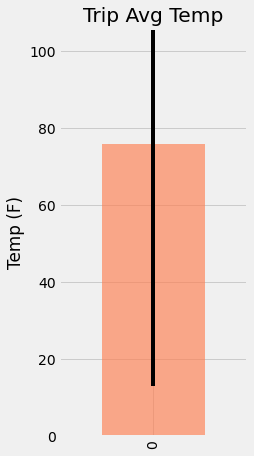

In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

for tmin, tavg, tmax in temp_results:
        temp_dict = {}
        temp_dict['tmin'] = tmin
        temp_dict['tavg'] = tavg
        temp_dict['tmax'] = tmax

temp_info = pd.DataFrame(temp_dict, index=[0]) 
yerr= [temp_info['tmin'], temp_info['tmax']]

temp_info['tavg'].plot.bar(yerr=yerr, width=0.6, alpha = 0.65, color='coral', figsize=(3, 7))
# plt.bar('A', temp_info['tavg'], yerr=yerr, width=0.6, alpha = 0.65, color='coral')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0, temp_info['tavg'].values+30)

### Daily Rainfall Average

In [37]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session = Session(engine)
rainfall = session.query(Measurement.station, Station.name, func.avg(Measurement.prcp), Station.latitude, \
                         Station.longitude, Station.elevation).filter(Measurement.station == Station.station). \
                         order_by(desc(func.avg(Measurement.prcp))).group_by(Measurement.station).all()
rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  0.4299879227053122,
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  0.2123520923520915,
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  0.20722222222222236,
  21.4992,
  -158.0111,
  306.6),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  0.14192136498516264,
  21.4234,
  -157.8015,
  14.6),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  0.12105833763551899,
  21.5213,
  -157.8374,
  7.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  0.11496111975116619,
  21.33556,
  -157.71139,
  19.5),
 ('USC00517948',
  'PEARL CITY, HI US',
  0.06360175695461204,
  21.3934,
  -157.9751,
  11.9),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  0.0490204841713224,
  21.2716,
  -157.8168,
  3.0),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  0.04797101449275366,
  21.3152,
  -157.9992,
  0.9)]

In [ ]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates


# Strip off the year and save a list of strings in the format %m-%d


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session

In [ ]:
session.close()